In [1]:
import warnings

import cv2
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from glob import iglob
from scipy.spatial.distance import cityblock, cosine

from machine_learning.fast import dimensionality_reduction as dr
from machine_learning.fast import k_nearest_neighbours as knn

In [2]:
warnings.filterwarnings('ignore')
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
def center(X):
    return X - np.mean(X, axis=0)

def standardize(X):
    return X / np.std(X, axis=0)

In [4]:
# Read image files
def read_images(directory_name):
    X = []; y = []
    for image in iglob("data/" + directory_name + "/*.pgm"):
        face = cv2.resize(plt.imread(image), (50, 60)).flatten()
        X = np.append(X, face)
        y = np.append(y, image.split("/")[2][:5]) # Select the substring in the name that contains the class
    X = np.reshape(X, (-1, 3000))
    return X, y

In [5]:
X, y = read_images("training_set")
Xt = np.transpose(X) # input data for ICA1
X = center(X); X = standardize(X)
Xt = center(Xt); Xt = standardize(Xt)

In [6]:
pca = dr.PCA(X, 400)
pcat = dr.PCA(Xt, 400)
ica1 = dr.ICA(np.dot(Xt, pcat.components), 400)
ica2 = dr.ICA(np.dot(X, pca.components), 400)
lda = dr.LDA(np.dot(X, pca.components), y, 400)

In [7]:
print("The cumulative variance of the first 400 components is " + str(round(pca.explained_variance, 2)) + "%")

The cumulative variance of the first 400 components is 98.95%


In [8]:
PC = pca.components
IC1 = np.dot(ica1.components, np.transpose(PC))
IC2 = np.dot(ica2.components, np.transpose(PC))
LD = np.dot(lda.components, np.transpose(PC))

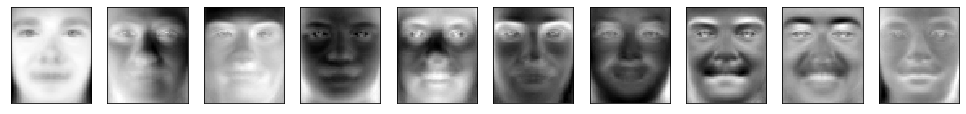

In [9]:
PC_ = np.transpose(PC) # for vizualization
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(PC_[i].reshape(60, 50), cmap="gray")

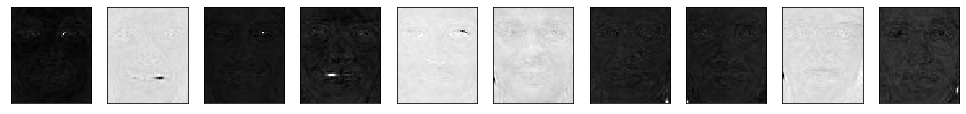

In [10]:
IC1_ = np.dot(ica1.components, np.dot(np.transpose(pcat.components), X)) # for vizualization
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC1_[i].reshape(60, 50), cmap="gray")

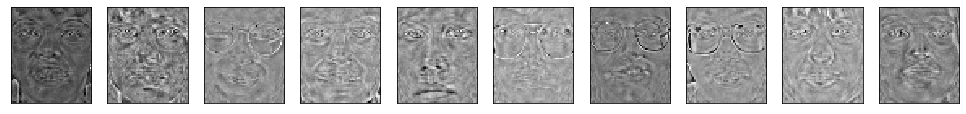

In [11]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC2[i].reshape(60, 50), cmap="gray")

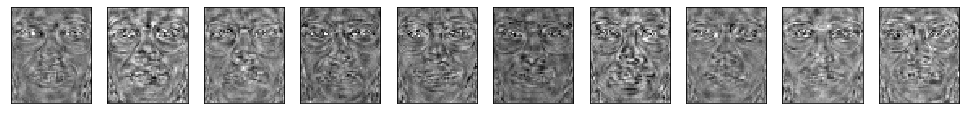

In [12]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(LD[i].reshape(60, 50), cmap="gray")

In [13]:
Xg, yg = read_images("gallery")
Xg = center(Xg); Xg = standardize(Xg)
Xg_pca = np.dot(Xg, PC)
Xg_ica1 = np.dot(Xg, np.transpose(IC1))
Xg_ica2 = np.dot(Xg, np.transpose(IC2))
Xg_lda = np.dot(Xg, np.transpose(LD))

In [14]:
Xfb, yfb = read_images("fb")
Xfb = center(Xfb); Xfb = standardize(Xfb)
Xfb_pca = np.dot(Xfb, PC)
Xfb_ica1 = np.dot(Xfb, np.transpose(IC1))
Xfb_ica2 = np.dot(Xfb, np.transpose(IC2))
Xfb_lda = np.dot(Xfb, np.transpose(LD))

In [15]:
Xfc, yfc = read_images("fc")
Xfc = center(Xfc); Xfc = standardize(Xfc)
Xfc_pca = np.dot(Xfc, PC)
Xfc_ica1 = np.dot(Xfc, np.transpose(IC1))
Xfc_ica2 = np.dot(Xfc, np.transpose(IC2))
Xfc_lda = np.dot(Xfc, np.transpose(LD))

In [16]:
Xd1, yd1 = read_images("dup1")
Xd1 = center(Xd1); Xd1 = standardize(Xd1)
Xd1_pca = np.dot(Xd1, PC)
Xd1_ica1 = np.dot(Xd1, np.transpose(IC1))
Xd1_ica2 = np.dot(Xd1, np.transpose(IC2))
Xd1_lda = np.dot(Xd1, np.transpose(LD))

In [17]:
Xd2, yd2 = read_images("dup2")
Xd2 = center(Xd2); Xd2 = standardize(Xd2)
Xd2_pca = np.dot(Xd2, PC)
Xd2_ica1 = np.dot(Xd2, np.transpose(IC1))
Xd2_ica2 = np.dot(Xd2, np.transpose(IC2))
Xd2_lda = np.dot(Xd2, np.transpose(LD))

In [18]:
# Faster than SciPy's Manhattan
def euclidean(a, b):
    return np.linalg.norm(a - b)

In [19]:
def performance(rank, knn_, X, y):
    true = 0; total = len(X)
    for i in range(total):
        if y[i] in knn_.find_knn(rank, X[i]):
            true += 1
    return round(true / total*100, 2)

In [20]:
# PCA kNN
pca_l1 = knn.kNN(Xg_pca, yg, cityblock, 100)
pca_l2 = knn.kNN(Xg_pca, yg, euclidean, 100)
pca_cos = knn.kNN(Xg_pca, yg, cosine, 100)

In [21]:
# ICA1 kNN
ica1_l1 = knn.kNN(Xg_ica1, yg, cityblock, 100)
ica1_l2 = knn.kNN(Xg_ica1, yg, euclidean, 100)
ica1_cos = knn.kNN(Xg_ica1, yg, cosine, 100)

In [22]:
# ICA2 kNN
ica2_l1 = knn.kNN(Xg_ica2, yg, cityblock, 100)
ica2_l2 = knn.kNN(Xg_ica2, yg, euclidean, 100)
ica2_cos = knn.kNN(Xg_ica2, yg, cosine, 100)

In [23]:
# LDA kNN
lda_l1 = knn.kNN(Xg_lda, yg, cityblock, 100)
lda_l2 = knn.kNN(Xg_lda, yg, euclidean, 100)
lda_cos = knn.kNN(Xg_lda, yg, cosine, 100)

# Fb probe set

In [24]:
print("PCA+L1: " + str(performance(1, pca_l1, Xfb_pca, yfb)))
print("PCA+L2: " + str(performance(1, pca_l2, Xfb_pca, yfb)))
print("PCA+COS: " + str(performance(1, pca_cos, Xfb_pca, yfb)))

PCA+L1: 72.72
PCA+L2: 66.19
PCA+COS: 69.29


In [25]:
print("ICA1+L1: " + str(performance(1, ica1_l1, Xfb_ica1, yfb)))
print("ICA1+L2: " + str(performance(1, ica1_l2, Xfb_ica1, yfb)))
print("ICA1+COS: " + str(performance(1, ica1_cos, Xfb_ica1, yfb)))

ICA1+L1: 47.7
ICA1+L2: 47.78
ICA1+COS: 77.15


In [26]:
print("ICA2+L1: " + str(performance(1, ica2_l1, Xfb_ica2, yfb)))
print("ICA2+L2: " + str(performance(1, ica2_l2, Xfb_ica2, yfb)))
print("ICA2+COS: " + str(performance(1, ica2_cos, Xfb_ica2, yfb)))

ICA2+L1: 42.68
ICA2+L2: 46.44
ICA2+COS: 76.82


In [27]:
print("LCA+L1: " + str(performance(1, lda_l1, Xfb_lda, yfb)))
print("LCA+L2: " + str(performance(1, lda_l2, Xfb_lda, yfb)))
print("LCA+COS: " + str(performance(1, lda_cos, Xfb_lda, yfb)))

LCA+L1: 78.16
LCA+L2: 66.19
LCA+COS: 69.29


# Fc probe set

In [28]:
print("PCA+L1: " + str(performance(1, pca_l1, Xfc_pca, yfc)))
print("PCA+L2: " + str(performance(1, pca_l2, Xfc_pca, yfc)))
print("PCA+COS: " + str(performance(1, pca_cos, Xfc_pca, yfc)))

PCA+L1: 66.49
PCA+L2: 30.93
PCA+COS: 38.66


In [29]:
print("ICA1+L1: " + str(performance(1, ica1_l1, Xfc_ica1, yfc)))
print("ICA1+L2: " + str(performance(1, ica1_l2, Xfc_ica1, yfc)))
print("ICA1+COS: " + str(performance(1, ica1_cos, Xfc_ica1, yfc)))

ICA1+L1: 46.39
ICA1+L2: 46.91
ICA1+COS: 72.68


In [30]:
print("ICA2+L1: " + str(performance(1, ica2_l1, Xfc_ica2, yfc)))
print("ICA2+L2: " + str(performance(1, ica2_l2, Xfc_ica2, yfc)))
print("ICA2+COS: " + str(performance(1, ica2_cos, Xfc_ica2, yfc)))

ICA2+L1: 37.11
ICA2+L2: 46.39
ICA2+COS: 70.62


In [31]:
print("LDA+L1: " + str(performance(1, lda_l1, Xfc_lda, yfc)))
print("LDA+L2: " + str(performance(1, lda_l2, Xfc_lda, yfc)))
print("LDA+COS: " + str(performance(1, lda_cos, Xfc_lda, yfc)))

LDA+L1: 71.65
LDA+L2: 30.93
LDA+COS: 38.66


# DUP1 probe set

In [32]:
print("PCA+L1: " + str(performance(1, pca_l1, Xd1_pca, yd1)))
print("PCA+L2: " + str(performance(1, pca_l2, Xd1_pca, yd1)))
print("PCA+COS: " + str(performance(1, pca_cos, Xd1_pca, yd1)))

PCA+L1: 30.89
PCA+L2: 20.64
PCA+COS: 23.82


In [33]:
print("ICA1+L1: " + str(performance(1, ica1_l1, Xd1_ica1, yd1)))
print("ICA1+L2: " + str(performance(1, ica1_l2, Xd1_ica1, yd1)))
print("ICA1+COS: " + str(performance(1, ica1_cos, Xd1_ica1, yd1)))

ICA1+L1: 14.82
ICA1+L2: 15.51
ICA1+COS: 38.09


In [34]:
print("ICA2+L1: " + str(performance(1, ica2_l1, Xd1_ica2, yd1)))
print("ICA2+L2: " + str(performance(1, ica2_l2, Xd1_ica2, yd1)))
print("ICA2+COS: " + str(performance(1, ica2_cos, Xd1_ica2, yd1)))

ICA2+L1: 10.53
ICA2+L2: 14.4
ICA2+COS: 38.64


In [35]:
print("LDA+L1: " + str(performance(1, lda_l1, Xd1_lda, yd1)))
print("LDA+L2: " + str(performance(1, lda_l2, Xd1_lda, yd1)))
print("LDA+COS: " + str(performance(1, lda_cos, Xd1_lda, yd1)))

LDA+L1: 38.64
LDA+L2: 20.64
LDA+COS: 23.96


# DUP2 probe set

In [36]:
print("PCA+L1: " + str(performance(1, pca_l1, Xd2_pca, yd2)))
print("PCA+L2: " + str(performance(1, pca_l2, Xd2_pca, yd2)))
print("PCA+COS: " + str(performance(1, pca_cos, Xd2_pca, yd2)))

PCA+L1: 19.23
PCA+L2: 10.68
PCA+COS: 14.53


In [37]:
print("ICA1+L1: " + str(performance(1, ica1_l1, Xd2_ica1, yd2)))
print("ICA1+L2: " + str(performance(1, ica1_l2, Xd2_ica1, yd2)))
print("ICA1+COS: " + str(performance(1, ica1_cos, Xd2_ica1, yd2)))

ICA1+L1: 8.55
ICA1+L2: 8.97
ICA1+COS: 33.76


In [38]:
print("ICA2+L1: " + str(performance(1, ica2_l1, Xd2_ica2, yd2)))
print("ICA2+L2: " + str(performance(1, ica2_l2, Xd2_ica2, yd2)))
print("ICA2+COS: " + str(performance(1, ica2_cos, Xd2_ica2, yd2)))

ICA2+L1: 6.84
ICA2+L2: 8.55
ICA2+COS: 33.76


In [39]:
print("LDA+L1: " + str(performance(1, lda_l1, Xd2_lda, yd2)))
print("LDA+L2: " + str(performance(1, lda_l2, Xd2_lda, yd2)))
print("LDA+COS: " + str(performance(1, lda_cos, Xd2_lda, yd2)))

LDA+L1: 23.08
LDA+L2: 10.68
LDA+COS: 14.53


# CMS curves

In [59]:
# Create a CSM plot
def CSM(nn, X, y):
    csm = []
    csm.append(performance(1, nn, X, y))
    for rank in range(5, 81, 5):
        csm.append(performance(rank, nn, X, y))
    return csm

In [ ]:
CMS_fb = pd.DataFrame()
CMS_fb["PCA_L1"] = CSM(pca_l1, Xfb_pca, yfb)
CMS_fb["PCA_L2"] = CSM(pca_l2, Xfb_pca, yfb)
CMS_fb["PCA_COS"] = CSM(pca_cos, Xfb_pca, yfb)

In [ ]:
CMS_fb = CMS_fb.reset_index().rename(columns={'index':'rank'})
CMS_fb['rank'] *= 5
CMS_fb.at[0, 'rank'] = 1

In [ ]:
CMS_fb = pd.melt(CMS_fb, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_fb).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(55, 100))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()